# Modeling Credit Risk with Lending Club data

#### Objective: Predict delinquency of a borrower
#### Metric: ROCAUC or PRAUC


The biggest question re this data is which features are pulled at origination time.
For the details on this, see stuff below:
- https://www.kaggle.com/datasets/wordsforthewise/lending-club/discussion/220358
- https://www.kaggle.com/code/tysonpo/columns-available-at-origination-answer/notebook

From those links above, it seems that most features are pulled at loan application/origination. 
The only features, pulled later, belong to the two groups:
- features, related to loan performance/payments.
- features, which clearly mention this in name/description. E.g., word 'last' in feature name.

### Business Problem

### Objective

### Summary of Results

In [137]:
pip install openpyxl

Note: you may need to restart the kernel to use updated packages.


In [138]:
import pandas as pd
import numpy as np
import seaborn as sns
import os, time, warnings, gzip, gc, random, math, shap, pickle, optuna, csv, sys
from IPython.display import display
from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
from matplotlib_venn import venn3, venn3_circles
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.preprocessing import LabelBinarizer, LabelEncoder, OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split, KFold
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, precision_recall_curve, auc
from sklearn.metrics import mean_squared_error, mean_absolute_error, roc_auc_score
from sklearn.inspection import permutation_importance
from category_encoders import MEstimateEncoder
from xgboost import XGBClassifier

pd.set_option('display.max_columns', 5000)
pd.set_option('display.max_rows', 400)

warnings.filterwarnings("ignore")

In [139]:
### target encoding ###
# source: https://www.kaggle.com/code/ryanholbrook/feature-engineering-for-house-prices/notebook

class CrossFoldEncoder:
    def __init__(self, encoder, **kwargs):
        self.encoder_ = encoder
        self.kwargs_ = kwargs  # keyword arguments for the encoder
        self.cv_ = KFold(n_splits=4)

    # Fit an encoder on one split and transform the feature on the
    # other. Iterating over the splits in all folds gives a complete
    # transformation. We also now have one trained encoder on each
    # fold.
    def fit_transform(self, X, y, cols):
        self.fitted_encoders_ = []
        self.cols_ = cols
        X_encoded = []
        for idx_encode, idx_train in self.cv_.split(X):
            fitted_encoder = self.encoder_(cols=cols, **self.kwargs_)
            fitted_encoder.fit(
                X.iloc[idx_encode, :], y.iloc[idx_encode],
            )
            X_encoded.append(fitted_encoder.transform(X.iloc[idx_train, :])[cols])
            self.fitted_encoders_.append(fitted_encoder)
        X_encoded = pd.concat(X_encoded)
        X_encoded.columns = [name + "_encoded" for name in X_encoded.columns]
        return X_encoded

    # To transform the test data, average the encodings learned from
    # each fold.
    def transform(self, X):
        from functools import reduce

        X_encoded_list = []
        for fitted_encoder in self.fitted_encoders_:
            X_encoded = fitted_encoder.transform(X)
            X_encoded_list.append(X_encoded[self.cols_])
        X_encoded = reduce(
            lambda x, y: x.add(y, fill_value=0), X_encoded_list
        ) / len(X_encoded_list)
        X_encoded.columns = [name + "_encoded" for name in X_encoded.columns]
        return X_encoded

In [140]:
time0 = time.time()

with open('../input/lc-800k-sample/LCLoans_141_800k.pkl', 'rb') as pickled_one:
    df = pickle.load(pickled_one)
    
display(df.head())

features_tokeep = ['loan_status',
 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'installment','issue_d',
 'purpose', 'title', 'initial_list_status', 'application_type',
 'grade', 'sub_grade', 'fico_range_high',
 'emp_title', 'emp_length', 'home_ownership', 'annual_inc', 'zip_code', 'addr_state',
 'dti',           
 'verification_status', 
 'mo_sin_rcnt_tl', 'mths_since_last_delinq', 'mths_since_last_major_derog', 'mths_since_last_record',
 'mths_since_recent_bc_dlq', 'mths_since_recent_revol_delinq',
 'num_tl_op_past_12m', 
 'earliest_cr_line', 'inq_last_6mths', 'inq_fi', 'inq_last_12m',
 'open_acc', 'acc_open_past_24mths', 'mort_acc', 'total_acc',
 'avg_cur_bal', 'il_util', 'tot_cur_bal', 
 'revol_bal', 'revol_util', 'max_bal_bc',                 
 'delinq_2yrs', 'acc_now_delinq', 'delinq_amnt', 'pub_rec', 'pub_rec_bankruptcies',
 'annual_inc_joint', 'dti_joint', 'verification_status_joint',
 'total_bal_ex_mort', 'tot_coll_amt', 'tax_liens', 'percent_bc_gt_75', 'pct_tl_nvr_dlq', 
 'open_rv_12m', 'open_il_12m', 'num_tl_90g_dpd_24m', 'num_tl_30dpd', 'num_tl_120dpd_2m',
 'num_accts_ever_120_pd']

df = df[features_tokeep]


df.drop(columns = ['il_util', 'max_bal_bc'], inplace=True)
# these are useful features, which I will preprocess later
    
df = df.sample(200000)
df.reset_index(inplace=True, drop=True)
display(df.shape, time.time()-time0, df.head())

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag
2,1077175,2400.0,2400.0,2400.0,36.0,15.96,84.330002,C,C5,NaN,10+ years,RENT,12252.0,Not Verified,Dec-2011,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,small_business,real estate business,606xx,IL,8.72,0.0,Nov-2001,735.0,739.0,2.0,NaN,NaN,2.0,0.0,2956.0,98.5,10.0,f,0.0,0.0,3005.666748,3005.669922,2400.000000,605.669983,0.0,0.000000,0.00,Jun-2014,649.909973,NaN,Jun-2017,739.0,735.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
8,1071795,5600.0,5600.0,5600.0,60.0,21.28,152.389999,F,F2,NaN,4 years,OWN,40000.0,Source Verified,Dec-2011,Charged Off,n,https://lendingclub.com/browse/loanDetail.acti...,small_business,Expand Business & Buy Debt Portfolio,958xx,CA,5.55,0.0,Apr-2004,675.0,679.0,2.0,NaN,NaN,11.0,0.0,5210.0,32.6,13.0,f,0.0,0.0,647.500000,647.500000,162.020004,294.940002,0.0,190.539993,2.09,Apr-2012,152.389999,NaN,Oct-2016,499.0,0.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
11,1069908,12000.0,12000.0,12000.0,36.0,12.69,402.540009,B,B5,UCLA,10+ years,OWN,75000.0,Source Verified,Dec-2011,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,debt_consolidation,Consolidation,913xx,CA,1

(200000, 61)

1.4194810390472412

,loan_status,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,issue_d,purpose,title,initial_list_status,application_type,grade,sub_grade,fico_range_high,emp_title,emp_length,home_ownership,annual_inc,zip_code,addr_state,dti,verification_status,mo_sin_rcnt_tl,mths_since_last_delinq,mths_since_last_major_derog,mths_since_last_record,mths_since_recent_bc_dlq,mths_since_recent_revol_delinq,num_tl_op_past_12m,earliest_cr_line,inq_last_6mths,inq_fi,inq_last_12m,open_acc,acc_open_past_24mths,mort_acc,total_acc,avg_cur_bal,tot_cur_bal,revol_bal,revol_util,delinq_2yrs,acc_now_delinq,delinq_amnt,pub_rec,pub_rec_bankruptcies,annual_inc_joint,dti_joint,verification_status_joint,total_bal_ex_mort,tot_coll_amt,tax_liens,percent_bc_gt_75,pct_tl_nvr_dlq,open_rv_12m,open_il_12m,num_tl_90g_dpd_24m,num_tl_30dpd,num_tl_120dpd_2m,num_accts_ever_120_pd
0,Fully Paid,17500.0,17500.0,17500.0,36.0,11.99,581.169983,Apr-2014,debt_consolidation,Debt consolidation,f,Individual,B,B3,704.0,Technologist,10+ years,MORTGAGE,70000.0,550xx,MN,14.450000,Source Verified,7.0,NaN,NaN,63.0,NaN,NaN,1.0,May-1998,0.0,NaN,NaN,11.0,2.0,1.0,24.0,17776.0,177759.0,17719.0,63.7,0.0,0.0,0.0,1.0,0.0,NaN,NaN,NaN,47027.0,0.0,0.0,60.0,100.000000,NaN,NaN,0.0,0.0,0.0,0.0
1,Fully Paid,40000.0,40000.0,40000.0,60.0,12.62,902.369995,Aug-2017,debt_consolidation,Debt consolidation,w,Individual,C,C1,709.0,Firefighter,10+ years,MORTGAGE,200000.0,021xx,MA,13.860000,Source Verified,4.0,55.0,NaN,NaN,55.0,55.0,4.0,Jan-2000,3.0,1.0,5.0,21.0,7.0,5.0,39.0,19569.0,410948.0,36454.0,36.9,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,61658.0,0.0,0.0,14.3,97.400002,3.0,1.0,0.0,0.0,0.0,0.0
2,Fully Paid,24000.0,24000.0,24000.0,60.0,19.99,635.719971,Jun-2015,home_improvement,Home improvement,f,Individual,E,E4,669.0,Sr. Information Security Analyst,2 years,MORTGAGE,100000.0,852xx,AZ,25.670000,Source Verified,1.0,44.0,44.0,NaN,NaN,NaN,4.0,Mar-1999,1.0,NaN,NaN,16.0,8.0,3.0,30.0,6640.0,99596.0,29289.0,62.7,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,99596.0,0.0,0.0,100.0,96.699997,NaN,NaN,0.0,0.0,0.0,1.0
3,Fully Paid,10000.0,10000.0,10000.0,36.0,8.24,314.480011,Oct-2016,debt_consolidation,Debt consolidation,w,Individual,B,B1,699.0,Care Coordination Liaison,< 1 year,RENT,69000.0,600xx,IL,24.660000,Source Verified,2.0,19.0,19.0,NaN,NaN,40.0,1.0,Apr-1999,1.0,0.0,1.0,15.0,3.0,3.0,22.0,2158.0,32373.0,15648.0,40.1,1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,32373.0,0.0,0.0,28.6,90.900002,1.0,0.0,1.0,0.0,0.0,1.0
4,Current,23000.0,23000.0,22725.0,36.0,11.06,753.650024,Oct-2018,credit_card,Credit card refinancing,f,Individual,B,B3,684.0,It technician,5 years,RENT,49500.0,330xx,FL,21.959999,Verified,8.0,NaN,NaN,NaN,NaN,NaN,1.0,Jan-2014,0.0,1.0,2.0,13.0,3.0,0.0,17.0,1765.0,22944.0,14400.0,33.6,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,22944.0,0.0,0.0,0.0,100.000000,0.0,1.0,0.0,0.0,0.0,0.0


In [141]:
### feature description:

f_desc = pd.read_excel('../input/lending-club-20072020q1/LCDataDictionary.xlsx')
f_desc.columns = ['colname','desc']
#display(f_desc.head())
#display(f_desc)
display(f_desc.loc[f_desc.colname=='open_acc','desc'], f_desc.loc[f_desc.colname=='total_acc','desc'])


73    The number of open credit lines in the borrowe...
Name: desc, dtype: object

99    The total number of credit lines currently in ...
Name: desc, dtype: object

In [142]:
# clean time features

df.issue_d = df.issue_d.astype('O')
df.earliest_cr_line = df.earliest_cr_line.astype('O')
df.issue_d = pd.to_datetime(df.issue_d, format='%b-%Y')
df.earliest_cr_line = pd.to_datetime(df.earliest_cr_line, format='%b-%Y')
df['year_issued']=df.issue_d.dt.year
df['month_issued']=df.issue_d.dt.month
df['year_earliest']=df.issue_d.dt.year
df['years_borrowing'] = (df.issue_d - df.earliest_cr_line)/ np.timedelta64(1, 'Y')
df['pub_rec_pa'] = df.pub_rec/df.years_borrowing
display(df.head())

,loan_status,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,issue_d,purpose,title,initial_list_status,application_type,grade,sub_grade,fico_range_high,emp_title,emp_length,home_ownership,annual_inc,zip_code,addr_state,dti,verification_status,mo_sin_rcnt_tl,mths_since_last_delinq,mths_since_last_major_derog,mths_since_last_record,mths_since_recent_bc_dlq,mths_since_recent_revol_delinq,num_tl_op_past_12m,earliest_cr_line,inq_last_6mths,inq_fi,inq_last_12m,open_acc,acc_open_past_24mths,mort_acc,total_acc,avg_cur_bal,tot_cur_bal,revol_bal,revol_util,delinq_2yrs,acc_now_delinq,delinq_amnt,pub_rec,pub_rec_bankruptcies,annual_inc_joint,dti_joint,verification_status_joint,total_bal_ex_mort,tot_coll_amt,tax_liens,percent_bc_gt_75,pct_tl_nvr_dlq,open_rv_12m,open_il_12m,num_tl_90g_dpd_24m,num_tl_30dpd,num_tl_120dpd_2m,num_accts_ever_120_pd,year_issued,month_issued,year_earliest,years_borrowing,pub_rec_pa
0,Fully Paid,17500.0,17500.0,17500.0,36.0,11.99,581.169983,2014-04-01,debt_consolidation,Debt consolidation,f,Individual,B,B3,704.0,Technologist,10+ years,MORTGAGE,70000.0,550xx,MN,14.450000,Source Verified,7.0,NaN,NaN,63.0,NaN,NaN,1.0,1998-05-01,0.0,NaN,NaN,11.0,2.0,1.0,24.0,17776.0,177759.0,17719.0,63.7,0.0,0.0,0.0,1.0,0.0,NaN,NaN,NaN,47027.0,0.0,0.0,60.0,100.000000,NaN,NaN,0.0,0.0,0.0,0.0,2014,4,2014,15.918191,0.062821
1,Fully Paid,40000.0,40000.0,40000.0,60.0,12.62,902.369995,2017-08-01,debt_consolidation,Debt consolidation,w,Individual,C,C1,709.0,Firefighter,10+ years,MORTGAGE,200000.0,021xx,MA,13.860000,Source Verified,4.0,55.0,NaN,NaN,55.0,55.0,4.0,2000-01-01,3.0,1.0,5.0,21.0,7.0,5.0,39.0,19569.0,410948.0,36454.0,36.9,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,61658.0,0.0,0.0,14.3,97.400002,3.0,1.0,0.0,0.0,0.0,0.0,2017,8,2017,17.582839,0.000000
2,Fully Paid,24000.0,24000.0,24000.0,60.0,19.99,635.719971,2015-06-01,home_improvement,Home improvement,f,Individual,E,E4,669.0,Sr. Information Security Analyst,2 years,MORTGAGE,100000.0,852xx,AZ,25.670000,Source Verified,1.0,44.0,44.0,NaN,NaN,NaN,4.0,1999-03-01,1.0,NaN,NaN,16.0,8.0,3.0,30.0,6640.0,99596.0,29289.0,62.7,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,99596.0,0.0,0.0,100.0,96.699997,NaN,NaN,0.0,0.0,0.0,1.0,2015,6,2015,16.252216,0.000000
3,Fully Paid,10000.0,10000.0,10000.0,36.0,8.24,314.480011,2016-10-01,debt_consolidation,Debt consolidation,w,Individual,B,B1,699.0,Care Coordination Liaison,< 1 year,RENT,69000.0,600xx,IL,24.660000,Source Verified,2.0,19.0,19.0,NaN,NaN,40.0,1.0,1999-04-01,1.0,0.0,1.0,15.0,3.0,3.0,22.0,2158.0,32373.0,15648.0,40.1,1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,32373.0,0.0,0.0,28.6,90.900002,1.0,0.0,1.0,0.0,0.0,1.0,2016,10,2016,17.503439,0.000000
4,Current,23000.0,23000.0,22725.0,36.0,11.06,753.650024,2018-10-01,credit_card,Credit card refinancing,f,Individual,B,B3,684.0,It technician,5 years,RENT,49500.0,330xx,FL,21.959999,Verified,8.0,NaN,NaN,NaN,NaN,NaN,1.0,2014-01-01,0.0,1.0,2.0,13.0,3.0,0.0,17.0,1765.0,22944.0,14400.0,33.6,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,22944.0,0.0,0.0,0.0,100.000000,0.0,1.0,0.0,0.0,0.0,0.0,2018,10,2018,4.747531,0.000000


In [143]:
# creating a target variable

display(df.loan_status.value_counts())
df.target=np.nan
#df.loc[df.loan_status.isin(['Fully Paid', 'Does not meet the credit policy. Status:Fully Paid']), 'target']=0
#df.loc[df.loan_status.isin(['Charged Off', 'Late (31-120 days)', 'Does not meet the credit policy. Status:Charged Off', 'Default']), 'target']=1
df.loc[df.loan_status.isin(['Fully Paid']), 'target']=0
df.loc[df.loan_status.isin(['Charged Off', 'Default']), 'target']=1
df=df[df['target'].isin([0,1])]
display(df.shape,df.loan_status.value_counts(), df.count(), sys.getsizeof(df)/1048576)
df.drop(columns='loan_status',inplace=True)

Fully Paid                                             102489
Current                                                 70381
Charged Off                                             24778
Late (31-120 days)                                       1132
In Grace Period                                           664
Late (16-30 days)                                         185
Does not meet the credit policy. Status:Fully Paid        160
Issued                                                    127
Does not meet the credit policy. Status:Charged Off        47
Default                                                    37
Name: loan_status, dtype: int64

(128643, 67)

Fully Paid                                             102489
Charged Off                                             24778
Late (31-120 days)                                       1132
Does not meet the credit policy. Status:Fully Paid        160
Does not meet the credit policy. Status:Charged Off        47
Default                                                    37
Current                                                     0
In Grace Period                                             0
Issued                                                      0
Late (16-30 days)                                           0
Name: loan_status, dtype: int64

loan_status                       128643
loan_amnt                         128643
funded_amnt                       128643
funded_amnt_inv                   128643
term                              128643
int_rate                          128643
installment                       128643
issue_d                           128643
purpose                           128643
title                             127179
initial_list_status               128643
application_type                  128643
grade                             128643
sub_grade                         128643
fico_range_high                   128643
emp_title                         119682
emp_length                        120699
home_ownership                    128643
annual_inc                        128642
zip_code                          128643
addr_state                        128643
dti                               128562
verification_status               128643
mo_sin_rcnt_tl                    123769
mths_since_last_

53.91848087310791

### Feature Preprocessing

In [144]:
# add key loan features
df.loc[df.annual_inc<1,'annual_inc']=1
df['lti']=df.loan_amnt/df.annual_inc
df['iti']=(df.installment*12)/df.annual_inc
df.loc[df.lti==np.inf, 'lti']=np.nan
df.loc[df.lti>2, 'lti']=5
df.loc[df.iti==np.inf, 'iti']=np.nan
df.loc[df.iti>1, 'iti']=2
df.loc[df.revol_util>100,'revol_util']=100

# add more features

df['zip_code'] = df.zip_code.str.rstrip('xx').astype(int)
df['joint'] = df.dti_joint.notnull().astype(int)

df['emp_length'] = df.emp_length.str.rstrip(' years')
df.loc[df.emp_length=='< 1','emp_length'] = 0
df.loc[df.emp_length=='10+','emp_length'] = 10
df['emp_length'] = df.emp_length.astype(np.float32)
display(df.emp_length.value_counts())

df.amnt_same = (df.loan_amnt == df.funded_amnt_inv).astype(int)
df['revol_balance_income'] = df.revol_bal/df.annual_inc
df['avg_cur_bal_inc'] = df.avg_cur_bal/df.annual_inc
df['tot_cur_bal_inc'] = df.tot_cur_bal/df.annual_inc
df['total_bal_ex_mort_inc'] = df.total_bal_ex_mort/df.annual_inc

df['low_fico'] = (df.fico_range_high<=659).astype(int)
df['open_cl_ratio']=df.open_acc/df.total_acc
df['hobo'] = (df.home_ownership=='None').astype(int)
df['was_bankrupt'] = (df.pub_rec_bankruptcies>0).astype(int)

df.drop(columns = ['annual_inc_joint', 'dti_joint', 'verification_status_joint', 'earliest_cr_line', 'issue_d'], inplace=True)

df.head()

10.0    42195
2.0     11615
0.0     10738
3.0     10378
1.0      8469
5.0      8049
4.0      7720
6.0      5920
8.0      5423
7.0      5410
9.0      4782
Name: emp_length, dtype: int64

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,purpose,title,initial_list_status,application_type,grade,sub_grade,fico_range_high,emp_title,emp_length,home_ownership,annual_inc,zip_code,addr_state,dti,verification_status,mo_sin_rcnt_tl,mths_since_last_delinq,mths_since_last_major_derog,mths_since_last_record,mths_since_recent_bc_dlq,mths_since_recent_revol_delinq,num_tl_op_past_12m,inq_last_6mths,inq_fi,inq_last_12m,open_acc,acc_open_past_24mths,mort_acc,total_acc,avg_cur_bal,tot_cur_bal,revol_bal,revol_util,delinq_2yrs,acc_now_delinq,delinq_amnt,pub_rec,pub_rec_bankruptcies,total_bal_ex_mort,tot_coll_amt,tax_liens,percent_bc_gt_75,pct_tl_nvr_dlq,open_rv_12m,open_il_12m,num_tl_90g_dpd_24m,num_tl_30dpd,num_tl_120dpd_2m,num_accts_ever_120_pd,year_issued,month_issued,year_earliest,years_borrowing,pub_rec_pa,target,lti,iti,joint,revol_balance_income,avg_cur_bal_inc,tot_cur_bal_inc,total_bal_ex_mort_inc,low_fico,open_cl_ratio,hobo,was_bankrupt
0,17500.0,17500.0,17500.0,36.0,11.99,581.169983,debt_consolidation,Debt consolidation,f,Individual,B,B3,704.0,Technologist,10.0,MORTGAGE,70000.0,550,MN,14.450000,Source Verified,7.0,NaN,NaN,63.0,NaN,NaN,1.0,0.0,NaN,NaN,11.0,2.0,1.0,24.0,17776.0,177759.0,17719.0,63.7,0.0,0.0,0.0,1.0,0.0,47027.0,0.0,0.0,60.0,100.000000,NaN,NaN,0.0,0.0,0.0,0.0,2014,4,2014,15.918191,0.062821,0.0,0.250000,0.099629,0,0.253129,0.253943,2.539414,0.671814,0,0.458333,0,0
1,40000.0,40000.0,40000.0,60.0,12.62,902.369995,debt_consolidation,Debt consolidation,w,Individual,C,C1,709.0,Firefighter,10.0,MORTGAGE,200000.0,21,MA,13.860000,Source Verified,4.0,55.0,NaN,NaN,55.0,55.0,4.0,3.0,1.0,5.0,21.0,7.0,5.0,39.0,19569.0,410948.0,36454.0,36.9,0.0,0.0,0.0,0.0,0.0,61658.0,0.0,0.0,14.3,97.400002,3.0,1.0,0.0,0.0,0.0,0.0,2017,8,2017,17.582839,0.000000,0.0,0.200000,0.054142,0,0.182270,0.097845,2.054740,0.308290,0,0.538462,0,0
2,24000.0,24000.0,24000.0,60.0,19.99,635.719971,home_improvement,Home improvement,f,Individual,E,E4,669.0,Sr. Information Security Analyst,2.0,MORTGAGE,100000.0,852,AZ,25.670000,Source Verified,1.0,44.0,44.0,NaN,NaN,NaN,4.0,1.0,NaN,NaN,16.0,8.0,3.0,30.0,6640.0,99596.0,29289.0,62.7,0.0,0.0,0.0,0.0,0.0,99596.0,0.0,0.0,100.0,96.699997,NaN,NaN,0.0,0.0,0.0,1.0,2015,6,2015,16.252216,0.000000,0.0,0.240000,0.076286,0,0.292890,0.066400,0.995960,0.995960,0,0.533333,0,0
3,10000.0,10000.0,10000.0,36.0,8.24,314.480011,debt_consolidation,Debt consolidation,w,Individual,B,B1,699.0,Care Coordination Liaison,0.0,RENT,69000.0,600,IL,24.660000,Source Verified,2.0,19.0,19.0,NaN,NaN,40.0,1.0,1.0,0.0,1.0,15.0,3.0,3.0,22.0,2158.0,32373.0,15648.0,40.1,1.0,0.0,0.0,0.0,0.0,32373.0,0.0,0.0,28.6,90.900002,1.0,0.0,1.0,0.0,0.0,1.0,2016,10,2016,17.503439,0.000000,0.0,0.144928,0.054692,0,0.226783,0.031275,0.469174,0.469174,0,0.681818,0,0
8,25000.0,25000.0,25000.0,60.0,18.55,642.340027,debt_consolidation,Debt consolidation,w,Individual,E,E2,694.0,Pricing Manager,10.0,MORTGAGE,102000.0,473,IN,18.120001,Not Verified,3.0,22.0,69.0,70.0,69.0,69.0,4.0,1.0,NaN,NaN,12.0,8.0,2.0,33.0,5662.0,67940.0,37093.0,20.1,1.0,0.0,0.0,1.0,1.0,67940.0,0.0,0.0,0.0,92.900002,NaN,NaN,0.0,0.0,0.0,1.0,2015,9,2015,27.417401,0.036473,0.0,0.245098,0.075569,0,0.363657,0.055510,0.666078,0.666078,0,0.363636,0,1


In [145]:
# For features like 'time_since some credit event', treat NA as never and fill those values with 100 years equivalent

df.mo_sin_rcnt_tl = df.mo_sin_rcnt_tl.fillna(value=120)
df.num_tl_op_past_12m = df.num_tl_op_past_12m.fillna(value=0)

months_since_col = ['mths_since_last_delinq', 'mths_since_last_major_derog', 
                    'mths_since_last_record', 'mths_since_recent_bc_dlq', 'mths_since_recent_revol_delinq']

for col in months_since_col:
    df[col] = df[col].fillna(value=1200)

display(df.count())

df.inq_fi = df.inq_fi.fillna(value=0)
df.inq_last_12m = df.inq_last_12m.fillna(value=0)



loan_amnt                         128643
funded_amnt                       128643
funded_amnt_inv                   128643
term                              128643
int_rate                          128643
installment                       128643
purpose                           128643
title                             127179
initial_list_status               128643
application_type                  128643
grade                             128643
sub_grade                         128643
fico_range_high                   128643
emp_title                         119682
emp_length                        120699
home_ownership                    128643
annual_inc                        128642
zip_code                          128643
addr_state                        128643
dti                               128562
verification_status               128643
mo_sin_rcnt_tl                    128643
mths_since_last_delinq            128643
mths_since_last_major_derog       128643
mths_since_last_

In [146]:
df.mo_sin_rcnt_tl.describe()

count    128643.000000
mean         12.293129
std          23.084938
min           0.000000
25%           3.000000
50%           6.000000
75%          11.000000
max         194.000000
Name: mo_sin_rcnt_tl, dtype: float64

In [147]:
df.verification_status.value_counts()

Source Verified    50829
Not Verified       41079
Verified           36735
Name: verification_status, dtype: int64

In [148]:
df.target.mean()

0.20206307377781924

In [149]:
cat_features_te = ['grade', 'sub_grade', 'emp_title', 'home_ownership', 'purpose', 'title', 'zip_code', 'addr_state']
cat_features_ohe = ['verification_status', 'initial_list_status', 'application_type']

In [150]:
df.application_type.value_counts()

Individual    123703
Joint App       4940
Name: application_type, dtype: int64

### EDA

In [151]:
display(df[['loan_amnt', 'funded_amnt', 'funded_amnt_inv']].describe())
# basically, the three features are identical

display(df.term.value_counts())

,loan_amnt,funded_amnt,funded_amnt_inv
count,128643.000000,128643.000000,128643.000000
mean,14615.898438,14610.174805,14588.644531
std,8995.984375,8993.842773,8998.103516
min,500.000000,500.000000,0.000000
25%,8000.000000,8000.000000,7900.000000
50%,12000.000000,12000.000000,12000.000000
75%,20000.000000,20000.000000,20000.000000
max,40000.000000,40000.000000,40000.000000


36.0    96210
60.0    32433
Name: term, dtype: int64

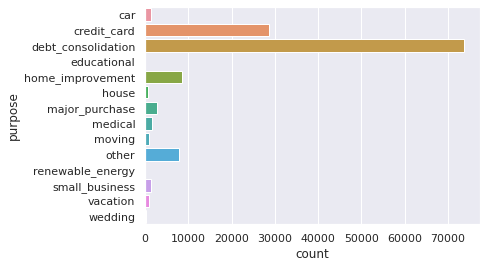

<AxesSubplot:xlabel='count', ylabel='emp_length'>

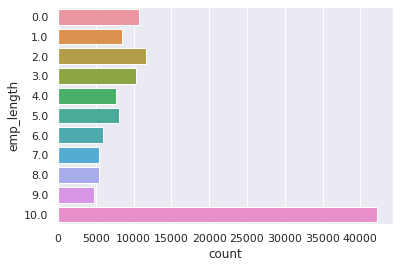

In [152]:
sns.countplot(y='purpose', data=df)
plt.show()
sns.countplot(y='emp_length', data=df)

In [153]:
#top_titles = (df.title.value_counts()[:10]).index
#tempdf = df[df.title.isin(list(top_titles))]
#sns.countplot(y='title', data=tempdf)

In [154]:
display(df.loc[df.target==1,'delinq_2yrs'].describe())
display(df.loc[df.target==0,'delinq_2yrs'].describe())
# i am not sure how this variable is defined. Is it at the moment of loan origination?

count    25994.000000
mean         0.330115
std          0.927368
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         25.000000
Name: delinq_2yrs, dtype: float64

count    102645.000000
mean          0.308890
std           0.875787
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          32.000000
Name: delinq_2yrs, dtype: float64

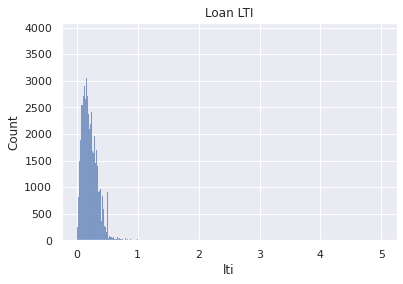

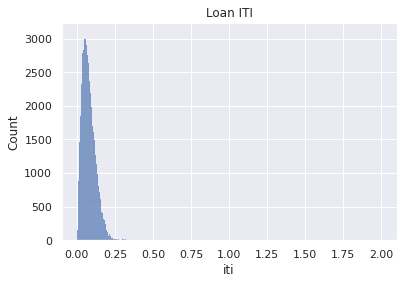

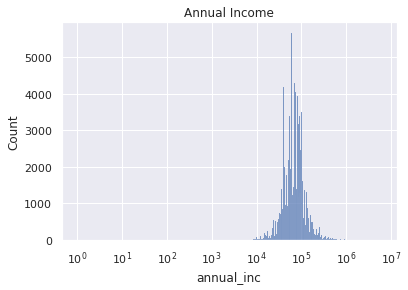

In [155]:
#sns.histplot(x='int_rate', data=df).set(title='Loan LTI')
#plt.show()
sns.histplot(x='lti', data=df).set(title='Loan LTI')
plt.show()
sns.histplot(x='iti', data=df).set(title='Loan ITI')
plt.show()
sns.histplot(x='annual_inc', data=df, log_scale=True).set(title='Annual Income')
plt.show()

[Text(0.5, 1.0, 'Loan Grade')]

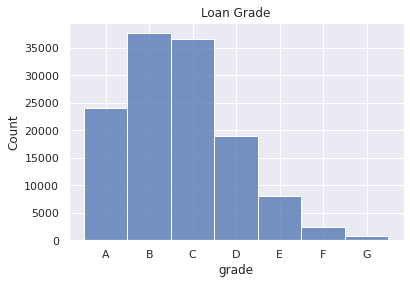

In [156]:
sns.histplot(x='grade', data=df).set(title='Loan Grade')

### EDA with target

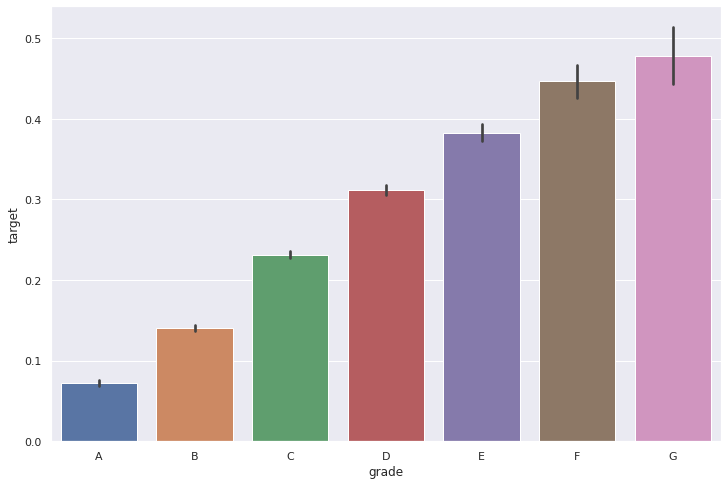

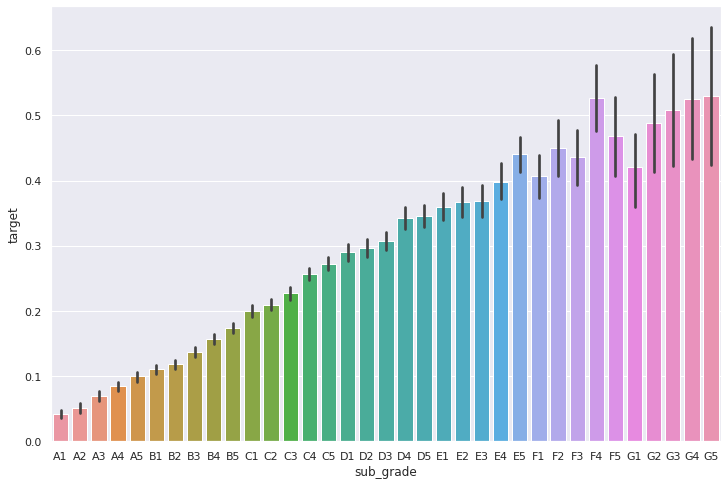

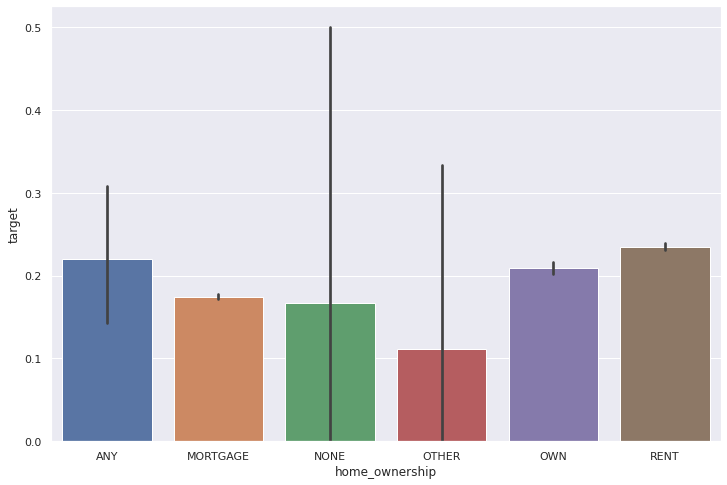

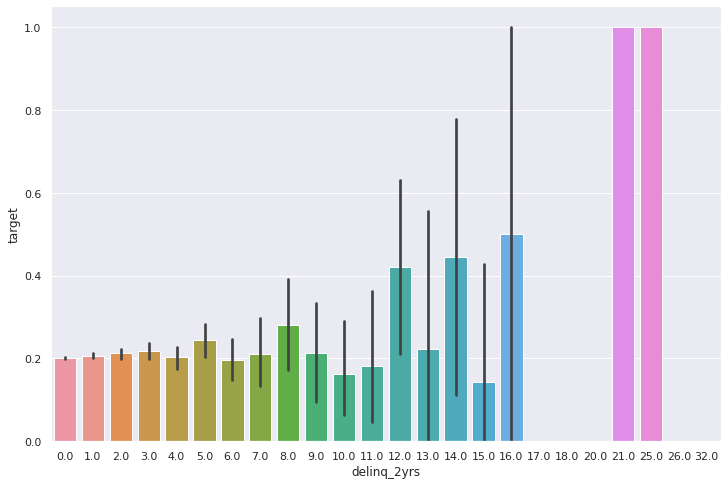

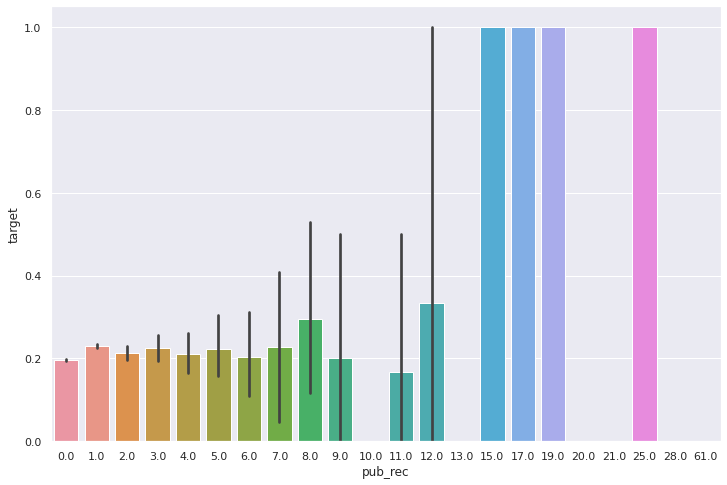

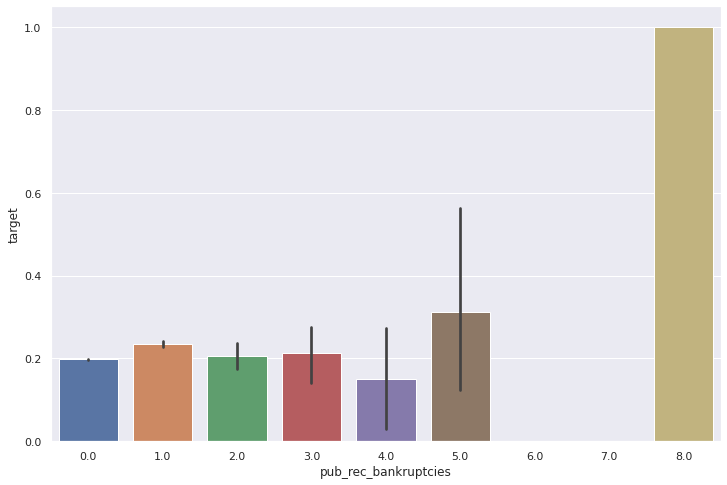

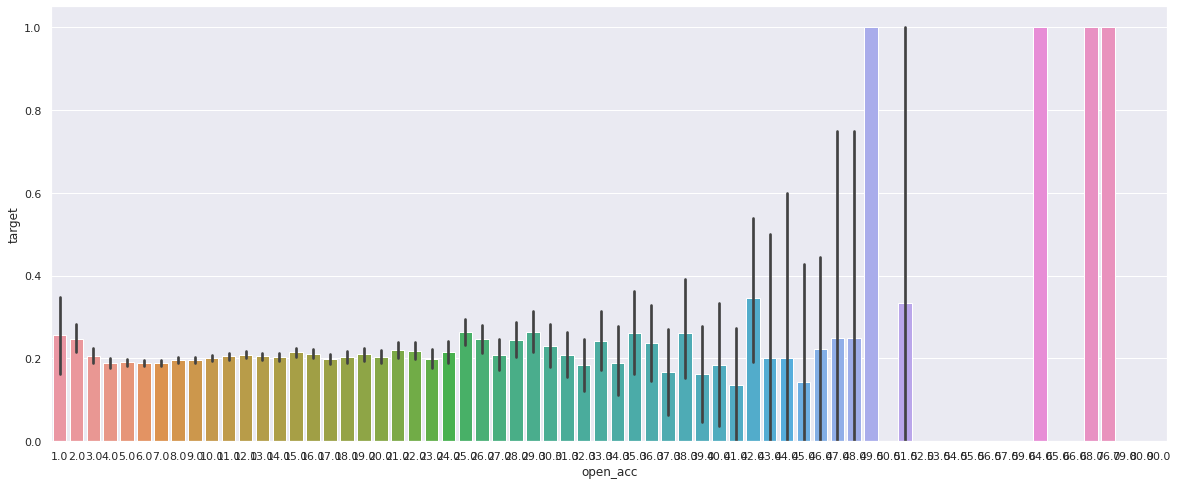

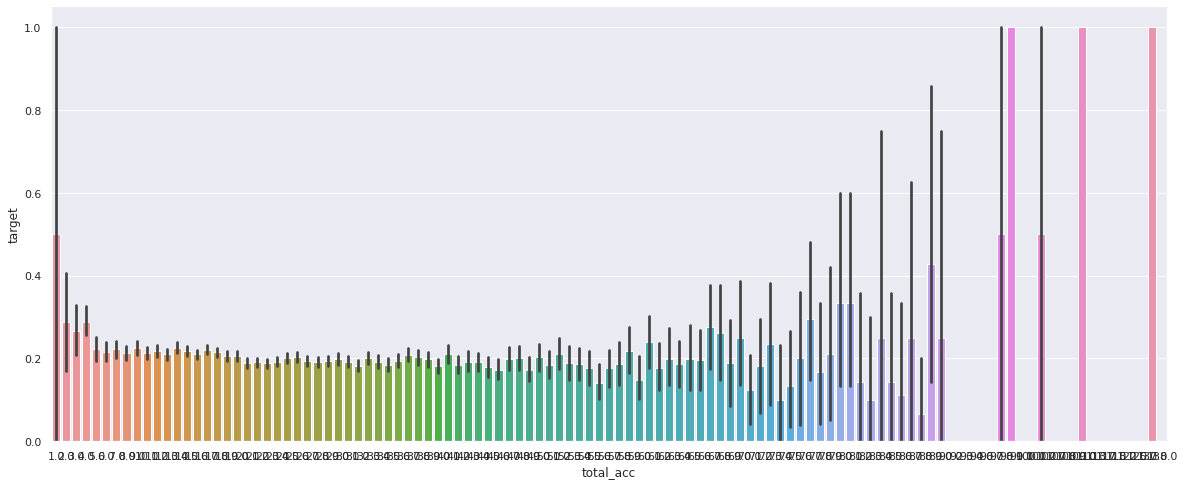

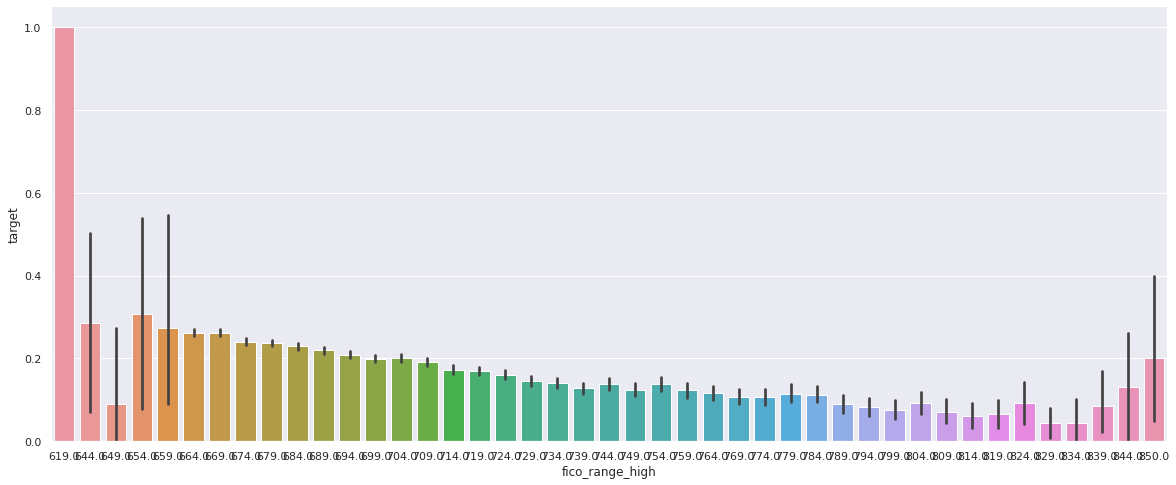

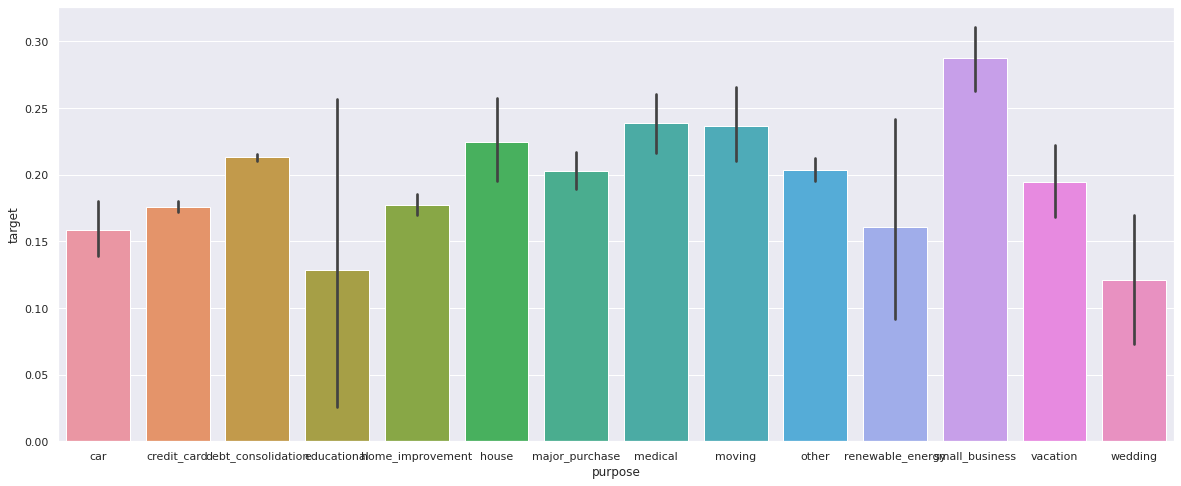

In [157]:
sns.set(rc={'figure.figsize':(12,8)})
sns.barplot(x='grade', y='target', data=df)
plt.show()
sns.barplot(x='sub_grade', y='target', data=df)
plt.show()
sns.barplot(x='home_ownership', y='target', data=df)
plt.show()
sns.barplot(x='delinq_2yrs', y='target', data=df)
plt.show()
sns.barplot(x='pub_rec', y='target', data=df)
plt.show()
sns.barplot(x='pub_rec_bankruptcies', y='target', data=df)
plt.show()
sns.set(rc={'figure.figsize':(20,8)})
sns.barplot(x='open_acc', y='target', data=df)
plt.show()
sns.barplot(x='total_acc', y='target', data=df)
plt.show()
sns.barplot(x='fico_range_high', y='target', data=df)
plt.show()
sns.barplot(x='purpose', y='target', data=df)
plt.show()

### Train-test split, missing values

In [158]:
display(df.count())

loan_amnt                         128643
funded_amnt                       128643
funded_amnt_inv                   128643
term                              128643
int_rate                          128643
installment                       128643
purpose                           128643
title                             127179
initial_list_status               128643
application_type                  128643
grade                             128643
sub_grade                         128643
fico_range_high                   128643
emp_title                         119682
emp_length                        120699
home_ownership                    128643
annual_inc                        128642
zip_code                          128643
addr_state                        128643
dti                               128562
verification_status               128643
mo_sin_rcnt_tl                    128643
mths_since_last_delinq            128643
mths_since_last_major_derog       128643
mths_since_last_

In [159]:
features_fill_M = ['emp_title', 'title']
features_fill_med = ['dti', 'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_util', 'total_acc', 'mort_acc', 'pub_rec_bankruptcies']

df['emp_length'] = df['emp_length'].fillna(value=0)

for col in features_fill_M:
    df[col] = df[col].cat.add_categories(['MISSING']) 
    df[col] = df[col].fillna(value='MISSING')

test_size = 0.1
df.reset_index(inplace=True, drop=True)
test_index = random.sample(list(df.index), int(test_size*df.shape[0]))
train = df.iloc[list(set(df.index)-set(test_index))]
test = df.iloc[test_index]
train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)
display(train.shape, test.shape, train.head(3), test.head(3))

for col in features_fill_med:
    train[col] = train[col].fillna(train[col].median())
    test[col] = test[col].fillna(train[col].median())

display(train.count(), test.count())

(115779, 72)

(12864, 72)

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,purpose,title,initial_list_status,application_type,grade,sub_grade,fico_range_high,emp_title,emp_length,home_ownership,annual_inc,zip_code,addr_state,dti,verification_status,mo_sin_rcnt_tl,mths_since_last_delinq,mths_since_last_major_derog,mths_since_last_record,mths_since_recent_bc_dlq,mths_since_recent_revol_delinq,num_tl_op_past_12m,inq_last_6mths,inq_fi,inq_last_12m,open_acc,acc_open_past_24mths,mort_acc,total_acc,avg_cur_bal,tot_cur_bal,revol_bal,revol_util,delinq_2yrs,acc_now_delinq,delinq_amnt,pub_rec,pub_rec_bankruptcies,total_bal_ex_mort,tot_coll_amt,tax_liens,percent_bc_gt_75,pct_tl_nvr_dlq,open_rv_12m,open_il_12m,num_tl_90g_dpd_24m,num_tl_30dpd,num_tl_120dpd_2m,num_accts_ever_120_pd,year_issued,month_issued,year_earliest,years_borrowing,pub_rec_pa,target,lti,iti,joint,revol_balance_income,avg_cur_bal_inc,tot_cur_bal_inc,total_bal_ex_mort_inc,low_fico,open_cl_ratio,hobo,was_bankrupt
0,17500.0,17500.0,17500.0,36.0,11.99,581.169983,debt_consolidation,Debt consolidation,f,Individual,B,B3,704.0,Technologist,10.0,MORTGAGE,70000.0,550,MN,14.45,Source Verified,7.0,1200.0,1200.0,63.0,1200.0,1200.0,1.0,0.0,0.0,0.0,11.0,2.0,1.0,24.0,17776.0,177759.0,17719.0,63.7,0.0,0.0,0.0,1.0,0.0,47027.0,0.0,0.0,60.0,100.000000,NaN,NaN,0.0,0.0,0.0,0.0,2014,4,2014,15.918191,0.062821,0.0,0.25,0.099629,0,0.253129,0.253943,2.539414,0.671814,0,0.458333,0,0
1,40000.0,40000.0,40000.0,60.0,12.62,902.369995,debt_consolidation,Debt consolidation,w,Individual,C,C1,709.0,Firefighter,10.0,MORTGAGE,200000.0,21,MA,13.86,Source Verified,4.0,55.0,1200.0,1200.0,55.0,55.0,4.0,3.0,1.0,5.0,21.0,7.0,5.0,39.0,19569.0,410948.0,36454.0,36.9,0.0,0.0,0.0,0.0,0.0,61658.0,0.0,0.0,14.3,97.400002,3.0,1.0,0.0,0.0,0.0,0.0,2017,8,2017,17.582839,0.000000,0.0,0.20,0.054142,0,0.182270,0.097845,2.054740,0.308290,0,0.538462,0,0
2,24000.0,24000.0,24000.0,60.0,19.99,635.719971,home_improvement,Home improvement,f,Individual,E,E4,669.0,Sr. Information Security Analyst,2.0,MORTGAGE,100000.0,852,AZ,25.67,Source Verified,1.0,44.0,44.0,1200.0,1200.0,1200.0,4.0,1.0,0.0,0.0,16.0,8.0,3.0,30.0,6640.0,99596.0,29289.0,62.7,0.0,0.0,0.0,0.0,0.0,99596.0,0.0,0.0,100.0,96.699997,NaN,NaN,0.0,0.0,0.0,1.0,2015,6,2015,16.252216,0.000000,0.0,0.24,0.076286,0,0.292890,0.066400,0.995960,0.995960,0,0.533333,0,0


,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,purpose,title,initial_list_status,application_type,grade,sub_grade,fico_range_high,emp_title,emp_length,home_ownership,annual_inc,zip_code,addr_state,dti,verification_status,mo_sin_rcnt_tl,mths_since_last_delinq,mths_since_last_major_derog,mths_since_last_record,mths_since_recent_bc_dlq,mths_since_recent_revol_delinq,num_tl_op_past_12m,inq_last_6mths,inq_fi,inq_last_12m,open_acc,acc_open_past_24mths,mort_acc,total_acc,avg_cur_bal,tot_cur_bal,revol_bal,revol_util,delinq_2yrs,acc_now_delinq,delinq_amnt,pub_rec,pub_rec_bankruptcies,total_bal_ex_mort,tot_coll_amt,tax_liens,percent_bc_gt_75,pct_tl_nvr_dlq,open_rv_12m,open_il_12m,num_tl_90g_dpd_24m,num_tl_30dpd,num_tl_120dpd_2m,num_accts_ever_120_pd,year_issued,month_issued,year_earliest,years_borrowing,pub_rec_pa,target,lti,iti,joint,revol_balance_income,avg_cur_bal_inc,tot_cur_bal_inc,total_bal_ex_mort_inc,low_fico,open_cl_ratio,hobo,was_bankrupt
0,9000.0,9000.0,9000.0,36.0,8.39,283.649994,home_improvement,Home improvement,w,Individual,B,B1,674.0,QA Manager,6.0,MORTGAGE,98500.0,857,AZ,23.730000,Not Verified,2.0,26.0,31.0,1200.0,1200.0,1200.0,1.0,0.0,0.0,2.0,18.0,1.0,2.0,24.0,14781.0,266066.0,33984.0,86.0,0.0,0.0,0.0,0.0,0.0,84926.0,0.0,0.0,100.0,91.699997,1.0,0.0,0.0,0.0,0.0,1.0,2016,4,2016,14.163193,0.000000,0.0,0.091371,0.034556,0,0.345015,0.150061,2.701178,0.862193,0,0.750000,0,0
1,30000.0,30000.0,30000.0,60.0,17.47,753.179993,debt_consolidation,Debt consolidation,w,Individual,D,D1,664.0,MISSING,0.0,RENT,54000.0,957,CA,19.930000,Source Verified,14.0,1200.0,1200.0,117.0,1200.0,1200.0,0.0,0.0,0.0,2.0,13.0,1.0,0.0,21.0,2366.0,30759.0,13841.0,75.1,0.0,0.0,0.0,1.0,1.0,30759.0,0.0,0.0,100.0,100.000000,0.0,0.0,0.0,0.0,0.0,0.0,2018,6,2018,12.747695,0.078446,1.0,0.555556,0.167373,0,0.256315,0.043815,0.569611,0.569611,0,0.619048,0,1
2,10000.0,10000.0,10000.0,36.0,8.39,315.170013,debt_consolidation,Debt consolidation,w,Individual,B,B1,694.0,MANAGER,9.0,MORTGAGE,51000.0,440,OH,33.360001,Source Verified,10.0,35.0,37.0,10.0,1200.0,1200.0,1.0,0.0,2.0,1.0,9.0,6.0,0.0,15.0,8528.0,76750.0,8545.0,61.9,0.0,0.0,0.0,1.0,0.0,76750.0,0.0,1.0,100.0,85.699997,0.0,1.0,0.0,0.0,0.0,1.0,2016,5,2016,12.835308,0.077910,0.0,0.196078,0.074158,0,0.167549,0.167216,1.504902,1.504902,0,0.600000,0,0


loan_amnt                         115779
funded_amnt                       115779
funded_amnt_inv                   115779
term                              115779
int_rate                          115779
installment                       115779
purpose                           115779
title                             115779
initial_list_status               115779
application_type                  115779
grade                             115779
sub_grade                         115779
fico_range_high                   115779
emp_title                         115779
emp_length                        115779
home_ownership                    115779
annual_inc                        115778
zip_code                          115779
addr_state                        115779
dti                               115779
verification_status               115779
mo_sin_rcnt_tl                    115779
mths_since_last_delinq            115779
mths_since_last_major_derog       115779
mths_since_last_

loan_amnt                         12864
funded_amnt                       12864
funded_amnt_inv                   12864
term                              12864
int_rate                          12864
installment                       12864
purpose                           12864
title                             12864
initial_list_status               12864
application_type                  12864
grade                             12864
sub_grade                         12864
fico_range_high                   12864
emp_title                         12864
emp_length                        12864
home_ownership                    12864
annual_inc                        12864
zip_code                          12864
addr_state                        12864
dti                               12864
verification_status               12864
mo_sin_rcnt_tl                    12864
mths_since_last_delinq            12864
mths_since_last_major_derog       12864
mths_since_last_record            12864


### Categorical features encoding

In [160]:
# TE for categorical features

test00 = test.copy()
time1 = time.time()
encoder = CrossFoldEncoder(MEstimateEncoder, m=10)
train_encoded = encoder.fit_transform(train, train.target, cols=cat_features_te)
test_encoded = encoder.transform(test)

train.drop(columns=cat_features_te, inplace=True)
test.drop(columns=cat_features_te,  inplace=True)
train = pd.concat([train, train_encoded], axis = 1)
test = pd.concat([test, test_encoded], axis = 1)

display(time.time()-time0, time.time()-time1)
display(train.shape, train.head(), train.count())
train0 = train.copy()
test0 = test.copy()

44.52290630340576

3.5874361991882324

(115779, 72)

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,initial_list_status,application_type,fico_range_high,emp_length,annual_inc,dti,verification_status,mo_sin_rcnt_tl,mths_since_last_delinq,mths_since_last_major_derog,mths_since_last_record,mths_since_recent_bc_dlq,mths_since_recent_revol_delinq,num_tl_op_past_12m,inq_last_6mths,inq_fi,inq_last_12m,open_acc,acc_open_past_24mths,mort_acc,total_acc,avg_cur_bal,tot_cur_bal,revol_bal,revol_util,delinq_2yrs,acc_now_delinq,delinq_amnt,pub_rec,pub_rec_bankruptcies,total_bal_ex_mort,tot_coll_amt,tax_liens,percent_bc_gt_75,pct_tl_nvr_dlq,open_rv_12m,open_il_12m,num_tl_90g_dpd_24m,num_tl_30dpd,num_tl_120dpd_2m,num_accts_ever_120_pd,year_issued,month_issued,year_earliest,years_borrowing,pub_rec_pa,target,lti,iti,joint,revol_balance_income,avg_cur_bal_inc,tot_cur_bal_inc,total_bal_ex_mort_inc,low_fico,open_cl_ratio,hobo,was_bankrupt,grade_encoded,sub_grade_encoded,emp_title_encoded,home_ownership_encoded,purpose_encoded,title_encoded,zip_code_encoded,addr_state_encoded
0,17500.0,17500.0,17500.0,36.0,11.99,581.169983,f,Individual,704.0,10.0,70000.0,14.450000,Source Verified,7.0,1200.0,1200.0,63.0,1200.0,1200.0,1.0,0.0,0.0,0.0,11.0,2.0,1.0,24.0,17776.0,177759.0,17719.0,63.7,0.0,0.0,0.0,1.0,0.0,47027.0,0.0,0.0,60.0,100.000000,NaN,NaN,0.0,0.0,0.0,0.0,2014,4,2014,15.918191,0.062821,0.0,0.250000,0.099629,0,0.253129,0.253943,2.539414,0.671814,0,0.458333,0,0,0.141689,0.140876,0.144109,0.174173,0.213895,0.219001,0.221238,0.198871
1,40000.0,40000.0,40000.0,60.0,12.62,902.369995,w,Individual,709.0,10.0,200000.0,13.860000,Source Verified,4.0,55.0,1200.0,1200.0,55.0,55.0,4.0,3.0,1.0,5.0,21.0,7.0,5.0,39.0,19569.0,410948.0,36454.0,36.9,0.0,0.0,0.0,0.0,0.0,61658.0,0.0,0.0,14.3,97.400002,3.0,1.0,0.0,0.0,0.0,0.0,2017,8,2017,17.582839,0.000000,0.0,0.200000,0.054142,0,0.182270,0.097845,2.054740,0.308290,0,0.538462,0,0,0.229158,0.199683,0.143692,0.174173,0.213895,0.219001,0.177500,0.197596
2,24000.0,24000.0,24000.0,60.0,19.99,635.719971,f,Individual,669.0,2.0,100000.0,25.670000,Source Verified,1.0,44.0,44.0,1200.0,1200.0,1200.0,4.0,1.0,0.0,0.0,16.0,8.0,3.0,30.0,6640.0,99596.0,29289.0,62.7,0.0,0.0,0.0,0.0,0.0,99596.0,0.0,0.0,100.0,96.699997,NaN,NaN,0.0,0.0,0.0,1.0,2015,6,2015,16.252216,0.000000,0.0,0.240000,0.076286,0,0.292890,0.066400,0.995960,0.995960,0,0.533333,0,0,0.379194,0.402660,0.201753,0.174173,0.178677,0.182766,0.188939,0.208655
3,10000.0,10000.0,10000.0,36.0,8.24,314.480011,w,Individual,699.0,0.0,69000.0,24.660000,Source Verified,2.0,19.0,19.0,1200.0,1200.0,40.0,1.0,1.0,0.0,1.0,15.0,3.0,3.0,22.0,2158.0,32373.0,15648.0,40.1,1.0,0.0,0.0,0.0,0.0,32373.0,0.0,0.0,28.6,90.900002,1.0,0.0,1.0,0.0,0.0,1.0,2016,10,2016,17.503439,0.000000,0.0,0.144928,0.054692,0,0.226783,0.031275,0.469174,0.469174,0,0.681818,0,0,0.141689,0.111161,0.201753,0.234540,0.213895,0.219001,0.186976,0.169069
4,25000.0,25000.0,25000.0,60.0,18.55,642.340027,w,Individual,694.0,10.0,102000.0,18.120001,Not Verified,3.0,22.0,69.0,70.0,69.0,69.0,4.0,1.0,0.0,0.0,12.0,8.0,2.0,33.0,5662.0,67940.0,37093.0,20.1,1.0,0.0,0.0,1.0,1.0,67940.0,0.0,0.0,0.0,92.900002,NaN,NaN,0.0,0.0,0.0,1.0,2015,9,2015,27.417401,0.036473,0.0,0.245098,0.075569,0,0.363657,0.055510,0.666078,0.666078,0,0.363636,0,1,0.379194,0.365430,0.168127,0.174173,0.213895,0.219001,0.217645,0.228424


loan_amnt                         115779
funded_amnt                       115779
funded_amnt_inv                   115779
term                              115779
int_rate                          115779
installment                       115779
initial_list_status               115779
application_type                  115779
fico_range_high                   115779
emp_length                        115779
annual_inc                        115778
dti                               115779
verification_status               115779
mo_sin_rcnt_tl                    115779
mths_since_last_delinq            115779
mths_since_last_major_derog       115779
mths_since_last_record            115779
mths_since_recent_bc_dlq          115779
mths_since_recent_revol_delinq    115779
num_tl_op_past_12m                115779
inq_last_6mths                    115779
inq_fi                            115779
inq_last_12m                      115779
open_acc                          115779
acc_open_past_24

In [161]:
X_train = train.copy()
y_train = X_train.pop('target')
X_test = test.copy()
y_test = X_test.pop('target')
display(X_test.head())

### Do OHE for some features ###

feature_transformer = ColumnTransformer([
    ("cat", OneHotEncoder(sparse = False, handle_unknown="ignore"), cat_features_ohe)], remainder="passthrough")

print('Number of features before transaformation: ', X_train.shape)
X_train = pd.DataFrame(feature_transformer.fit_transform(X_train), columns=feature_transformer.get_feature_names_out())
X_test = pd.DataFrame(feature_transformer.transform(X_test), columns=feature_transformer.get_feature_names_out())
print('time to do feature proprocessing: ', time.time()-time1)
print('Number of features after transaformation: ', X_train.shape)
X_train.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,initial_list_status,application_type,fico_range_high,emp_length,annual_inc,dti,verification_status,mo_sin_rcnt_tl,mths_since_last_delinq,mths_since_last_major_derog,mths_since_last_record,mths_since_recent_bc_dlq,mths_since_recent_revol_delinq,num_tl_op_past_12m,inq_last_6mths,inq_fi,inq_last_12m,open_acc,acc_open_past_24mths,mort_acc,total_acc,avg_cur_bal,tot_cur_bal,revol_bal,revol_util,delinq_2yrs,acc_now_delinq,delinq_amnt,pub_rec,pub_rec_bankruptcies,total_bal_ex_mort,tot_coll_amt,tax_liens,percent_bc_gt_75,pct_tl_nvr_dlq,open_rv_12m,open_il_12m,num_tl_90g_dpd_24m,num_tl_30dpd,num_tl_120dpd_2m,num_accts_ever_120_pd,year_issued,month_issued,year_earliest,years_borrowing,pub_rec_pa,lti,iti,joint,revol_balance_income,avg_cur_bal_inc,tot_cur_bal_inc,total_bal_ex_mort_inc,low_fico,open_cl_ratio,hobo,was_bankrupt,grade_encoded,sub_grade_encoded,emp_title_encoded,home_ownership_encoded,purpose_encoded,title_encoded,zip_code_encoded,addr_state_encoded
0,9000.0,9000.0,9000.0,36.0,8.39,283.649994,w,Individual,674.0,6.0,98500.0,23.730000,Not Verified,2.0,26.0,31.0,1200.0,1200.0,1200.0,1.0,0.0,0.0,2.0,18.0,1.0,2.0,24.0,14781.0,266066.0,33984.0,86.0,0.0,0.0,0.0,0.0,0.0,84926.0,0.0,0.0,100.000000,91.699997,1.0,0.0,0.0,0.0,0.0,1.0,2016,4,2016,14.163193,0.000000,0.091371,0.034556,0,0.345015,0.150061,2.701178,0.862193,0,0.750000,0,0,0.140970,0.110225,0.174344,0.174632,0.177878,0.182138,0.224982,0.209561
1,30000.0,30000.0,30000.0,60.0,17.47,753.179993,w,Individual,664.0,0.0,54000.0,19.930000,Source Verified,14.0,1200.0,1200.0,117.0,1200.0,1200.0,0.0,0.0,0.0,2.0,13.0,1.0,0.0,21.0,2366.0,30759.0,13841.0,75.1,0.0,0.0,0.0,1.0,1.0,30759.0,0.0,0.0,100.000000,100.000000,0.0,0.0,0.0,0.0,0.0,0.0,2018,6,2018,12.747695,0.078446,0.555556,0.167373,0,0.256315,0.043815,0.569611,0.569611,0,0.619048,0,1,0.310480,0.285851,0.276586,0.234122,0.213693,0.218696,0.179978,0.200895
2,10000.0,10000.0,10000.0,36.0,8.39,315.170013,w,Individual,694.0,9.0,51000.0,33.360001,Source Verified,10.0,35.0,37.0,10.0,1200.0,1200.0,1.0,0.0,2.0,1.0,9.0,6.0,0.0,15.0,8528.0,76750.0,8545.0,61.9,0.0,0.0,0.0,1.0,0.0,76750.0,0.0,1.0,100.000000,85.699997,0.0,1.0,0.0,0.0,0.0,1.0,2016,5,2016,12.835308,0.077910,0.196078,0.074158,0,0.167549,0.167216,1.504902,1.504902,0,0.600000,0,0,0.140970,0.110225,0.218211,0.174632,0.213693,0.218696,0.187552,0.189589
3,12000.0,12000.0,12000.0,60.0,13.99,279.160004,w,Individual,689.0,10.0,102000.0,12.080000,Source Verified,4.0,1200.0,1200.0,112.0,1200.0,1200.0,3.0,0.0,0.0,0.0,8.0,3.0,0.0,12.0,4896.0,39164.0,9518.0,51.2,0.0,0.0,0.0,1.0,1.0,39164.0,0.0,0.0,50.000000,100.000000,NaN,NaN,0.0,0.0,0.0,0.0,2015,3,2015,11.077572,0.090272,0.117647,0.032842,0,0.093314,0.048000,0.383961,0.383961,0,0.666667,0,1,0.231567,0.258536,0.202031,0.174632,0.213693,0.218696,0.198427,0.218733
4,6000.0,6000.0,6000.0,36.0,14.49,206.500000,w,Individual,664.0,0.0,55000.0,11.410000,Source Verified,11.0,27.0,1200.0,1200.0,1200.0,1200.0,1.0,1.0,0.0,0.0,12.0,4.0,0.0,20.0,1841.0,22094.0,12782.0,85.2,0.0,0.0,0.0,0.0,0.0,22094.0,0.0,0.0,85.699997,100.000000,NaN,NaN,0.0,0.0,0.0,0.0,2014,6,2014,13.747031,0.000000,0.109091,0.045055,0,0.232400,0.033473,0.401709,0.401709,0,0.600000,0,0,0.231567,0.258536,0.276586,0.234122,0.174384,0.178725,0.184884,0.200895


Number of features before transaformation:  (115779, 71)
time to do feature proprocessing:  4.02605128288269
Number of features after transaformation:  (115779, 75)


,cat__verification_status_Not Verified,cat__verification_status_Source Verified,cat__verification_status_Verified,cat__initial_list_status_f,cat__initial_list_status_w,cat__application_type_Individual,cat__application_type_Joint App,remainder__loan_amnt,remainder__funded_amnt,remainder__funded_amnt_inv,remainder__term,remainder__int_rate,remainder__installment,remainder__fico_range_high,remainder__emp_length,remainder__annual_inc,remainder__dti,remainder__mo_sin_rcnt_tl,remainder__mths_since_last_delinq,remainder__mths_since_last_major_derog,remainder__mths_since_last_record,remainder__mths_since_recent_bc_dlq,remainder__mths_since_recent_revol_delinq,remainder__num_tl_op_past_12m,remainder__inq_last_6mths,remainder__inq_fi,remainder__inq_last_12m,remainder__open_acc,remainder__acc_open_past_24mths,remainder__mort_acc,remainder__total_acc,remainder__avg_cur_bal,remainder__tot_cur_bal,remainder__revol_bal,remainder__revol_util,remainder__delinq_2yrs,remainder__acc_now_delinq,remainder__delinq_amnt,remainder__pub_rec,remainder__pub_rec_bankruptcies,remainder__total_bal_ex_mort,remainder__tot_coll_amt,remainder__tax_liens,remainder__percent_bc_gt_75,remainder__pct_tl_nvr_dlq,remainder__open_rv_12m,remainder__open_il_12m,remainder__num_tl_90g_dpd_24m,remainder__num_tl_30dpd,remainder__num_tl_120dpd_2m,remainder__num_accts_ever_120_pd,remainder__year_issued,remainder__month_issued,remainder__year_earliest,remainder__years_borrowing,remainder__pub_rec_pa,remainder__lti,remainder__iti,remainder__joint,remainder__revol_balance_income,remainder__avg_cur_bal_inc,remainder__tot_cur_bal_inc,remainder__total_bal_ex_mort_inc,remainder__low_fico,remainder__open_cl_ratio,remainder__hobo,remainder__was_bankrupt,remainder__grade_encoded,remainder__sub_grade_encoded,remainder__emp_title_encoded,remainder__home_ownership_encoded,remainder__purpose_encoded,remainder__title_encoded,remainder__zip_code_encoded,remainder__addr_state_encoded
0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,17500.0,17500.0,17500.0,36.0,11.99,581.169983,704.0,10.0,70000.0,14.450000,7.0,1200.0,1200.0,63.0,1200.0,1200.0,1.0,0.0,0.0,0.0,11.0,2.0,1.0,24.0,17776.0,177759.0,17719.0,63.7,0.0,0.0,0.0,1.0,0.0,47027.0,0.0,0.0,60.0,100.000000,NaN,NaN,0.0,0.0,0.0,0.0,2014.0,4.0,2014.0,15.918191,0.062821,0.250000,0.099629,0.0,0.253129,0.253943,2.539414,0.671814,0.0,0.458333,0.0,0.0,0.141689,0.140876,0.144109,0.174173,0.213895,0.219001,0.221238,0.198871
1,0.0,1.0,0.0,0.0,1.0,1.0,0.0,40000.0,40000.0,40000.0,60.0,12.62,902.369995,709.0,10.0,200000.0,13.860000,4.0,55.0,1200.0,1200.0,55.0,55.0,4.0,3.0,1.0,5.0,21.0,7.0,5.0,39.0,19569.0,410948.0,36454.0,36.9,0.0,0.0,0.0,0.0,0.0,61658.0,0.0,0.0,14.3,97.400002,3.0,1.0,0.0,0.0,0.0,0.0,2017.0,8.0,2017.0,17.582839,0.000000,0.200000,0.054142,0.0,0.182270,0.097845,2.054740,0.308290,0.0,0.538462,0.0,0.0,0.229158,0.199683,0.143692,0.174173,0.213895,0.219001,0.177500,0.197596
2,0.0,1.0,0.0,1.0,0.0,1.0,0.0,24000.0,24000.0,24000.0,60.0,19.99,635.719971,669.0,2.0,100000.0,25.670000,1.0,44.0,44.0,1200.0,1200.0,1200.0,4.0,1.0,0.0,0.0,16.0,8.0,3.0,30.0,6640.0,99596.0,29289.0,62.7,0.0,0.0,0.0,0.0,0.0,99596.0,0.0,0.0,100.0,96.699997,NaN,NaN,0.0,0.0,0.0,1.0,2015.0,6.0,2015.0,16.252216,0.000000,0.240000,0.076286,0.0,0.292890,0.066400,0.995960,0.995960,0.0,0.533333,0.0,0.0,0.379194,0.402660,0.201753,0.174173,0.178677,0.182766,0.188939,0.208655
3,0.0,1.0,0.0,0.0,1.0,1.0,0.0,10000.0,10000.0,10000.0,36.0,8.24,314.480011,699.0,0.0,69000.0,24.660000,2.0,19.0,19.0,1200.0,1200.0,40.0,1.0,1.0,0.0,1.0,15.0,3.0,3.0,22.0,2158.0,32373.0,15648.0,40.1,1.0,0.0,0.0,0.0,0.0,32373.0,0.0,0.0,28.6,90.900002,1.0,0.0,1.0,0.0,0.0,1.0,2016.0,10.0,2016.0,17.503439,0.000000,0.144928,0.054692,0.0,0.226783,0.031275,0.469174,0.469174,0.0,0.681818,0.0,0.0,0.141689,0.111161,0.201753,0.234540,0.213895,0.219001,0.186976,0.169069
4,1.0,0.0,0.0,0.0,1.0,1.0,0.0,25000.0,25000.0,25000.0,60.0,18.55,642.340027,694.0,10.0,102000.0,18.120001,3.0,22.0,69.0,70.0,69.0,69.0,4.0,1.0,0.0,0.0,12.0,8.0,2.0,33.0,5662.0,67940.0,3

### Modeling

In [162]:
time1 = time.time()
xgb = XGBClassifier(tree_method = 'gpu_hist')
xgb.fit(X_train, y_train)

precision_t, recall_t, threshold = precision_recall_curve(y_train, xgb.predict_proba(X_train)[:, 1])
auc_precision_recall_train = auc(recall_t, precision_t)
temp = recall_t[(recall_t>0.195)&(recall_t<0.205)]
temp = temp[int(len(temp)/2)]
indexx = ((np.where(recall_t==temp)))[0][0]
r20prec_train = precision_t[indexx]
precision_t, recall_t, threshold = precision_recall_curve(y_test, xgb.predict_proba(X_test)[:, 1])
auc_precision_recall_test = auc(recall_t, precision_t)
temp = recall_t[(recall_t>0.195)&(recall_t<0.205)]
temp = temp[int(len(temp)/2)]
indexx = ((np.where(recall_t==temp)))[0][0]
r20prec_test = precision_t[indexx]

display('Train Accuracy: ', accuracy_score(y_train,xgb.predict(X_train)))
display('F1 score: ', f1_score(y_train,xgb.predict(X_train)))
display('ROCAUC: ', roc_auc_score(y_train,xgb.predict(X_train)))
display('PRAUC: ', auc_precision_recall_train)
display('R20P: ', r20prec_train)

# Performance evaluation:
display('Test Accuracy: ', accuracy_score(y_test,xgb.predict(X_test)))
display('F1 score: ', f1_score(y_test,xgb.predict(X_test)))
display('ROCAUC: ', roc_auc_score(y_test,xgb.predict(X_test)))
display('PRAUC: ', auc_precision_recall_test)
display('R20P: ', r20prec_test)
display(time.time()-time1)

'Train Accuracy: '

0.8383731073856227

'F1 score: '

0.3888036058398929

'ROCAUC: '

0.6203335863606024

'PRAUC: '

0.6428095522686053

'R20P: '

0.863225806451613

'Test Accuracy: '

0.7985074626865671

'F1 score: '

0.22255548890221954

'ROCAUC: '

0.5537217763510299

'PRAUC: '

0.39405512159200806

'R20P: '

0.4822761194029851

3.8128206729888916

In [163]:
### Fit XGBoost using Optuna hyperparameter optimization ###

def objective(trial, cv_runs=1, n_splits=2, n_jobs=-1, scale_pos_weight=1):

    cv_regularizer=0.075
    # Usually values between 0.1 and 0.2 work fine.

    params = {
        "tree_method": 'gpu_hist',
        "verbosity": 0,  # 0 (silent) - 3 (debug)
        "n_estimators": trial.suggest_int("n_estimators", 700, 1000),
        "max_depth": trial.suggest_int("max_depth", 2, 10),
        "learning_rate": trial.suggest_uniform("learning_rate", 0.01, 0.4),
        "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.1, 0.95),
        "subsample": trial.suggest_uniform("subsample", 0.5, 0.95),
        "alpha": trial.suggest_loguniform("alpha", 0.1, 10.0),
        "lambda": trial.suggest_loguniform("lambda", 0.1, 150.0),
        "gamma": trial.suggest_loguniform("gamma", 1e-10, 10.0),
        "min_child_weight": trial.suggest_loguniform("min_child_weight", 0.1, 10),
        "n_jobs": n_jobs,
    }
    # usually it makes sense to resrtict hyperparameter space from some solutions which Optuna will find
    # e.g., for tmx-joined data only (downsampled tmx), optuna keeps selecting depths of 2 and 3.
    # for my purposes (smooth left side of prc, close to 1), those solutions are no good.

    temp_out = []

    for i in range(cv_runs):

        X = X_train
        y = y_train

        model = XGBClassifier(**params)
        rkf = KFold(n_splits=n_splits, shuffle=True)
        X_values = X.values
        y_values = y.values
        y_pred = np.zeros_like(y_values)
        y_pred_train = np.zeros_like(y_values)
        for train_index, test_index in rkf.split(X_values):
            X_A, X_B = X_values[train_index, :], X_values[test_index, :]
            y_A, y_B = y_values[train_index], y_values[test_index]
            model.fit(X_A, y_A, eval_set=[(X_B, y_B)], verbose = False)
            y_pred[test_index] += model.predict(X_B)
            y_pred_train[train_index] += model.predict(X_A)
        score_train = roc_auc_score(y_train, y_pred_train)
        score_test = roc_auc_score(y_train, y_pred) 
        overfit = score_train-score_test
        #return (score_test)
        #return (score_test-cv_regularizer*overfit)
        temp_out.append(score_test-cv_regularizer*overfit)

    return (np.mean(temp_out))

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)
print('Total time for hypermarameter optimization ', time.time()-time1)
hp = study.best_params
for key, value in hp.items():
    print(f"{key:>20s} : {value}")
print(f"{'best objective value':>20s} : {study.best_value}")

optuna_hyperpars = study.best_params
optuna_hyperpars['tree_method']='gpu_hist'
optuna_hyperpars['scale_pos_weight']=1

optuna_xgb = XGBClassifier(**optuna_hyperpars)
optuna_xgb.fit(X_train, y_train)

precision_t, recall_t, threshold = precision_recall_curve(y_train, optuna_xgb.predict_proba(X_train)[:, 1])
auc_precision_recall_train = auc(recall_t, precision_t)
temp = recall_t[(recall_t>0.195)&(recall_t<0.205)]
temp = temp[int(len(temp)/2)]
indexx = ((np.where(recall_t==temp)))[0][0]
r20prec_train = precision_t[indexx]
precision_t, recall_t, threshold = precision_recall_curve(y_test, optuna_xgb.predict_proba(X_test)[:, 1])
auc_precision_recall_test = auc(recall_t, precision_t)
temp = recall_t[(recall_t>0.195)&(recall_t<0.205)]
temp = temp[int(len(temp)/2)]
indexx = ((np.where(recall_t==temp)))[0][0]
r20prec_test = precision_t[indexx]

display('Train Accuracy: ', accuracy_score(y_train,optuna_xgb.predict(X_train)))
display('F1 score: ', f1_score(y_train,optuna_xgb.predict(X_train)))
display('ROCAUC: ', roc_auc_score(y_train,optuna_xgb.predict(X_train)))
display('PRAUC: ', auc_precision_recall_train)
display('R20P: ', r20prec_train)
# Performance evaluation:
display('Test Accuracy: ', accuracy_score(y_test,optuna_xgb.predict(X_test)))
display('F1 score: ', f1_score(y_test,optuna_xgb.predict(X_test)))
display('ROCAUC: ', roc_auc_score(y_test,optuna_xgb.predict(X_test)))
display('PRAUC: ', auc_precision_recall_test)
display('R20P: ', r20prec_test)
display(time.time()-time1)

[I 2022-08-12 21:05:02,597] A new study created in memory with name: no-name-27c7e95c-8da2-4159-a6dd-80a4d35788af
[I 2022-08-12 21:05:36,488] Trial 0 finished with value: 0.5242382228159953 and parameters: {'n_estimators': 809, 'max_depth': 9, 'learning_rate': 0.2528131573957445, 'colsample_bytree': 0.1841325202159198, 'subsample': 0.5717840843890811, 'alpha': 0.4066441998767169, 'lambda': 8.101893221215844, 'gamma': 1.402878056462878e-10, 'min_child_weight': 3.570503939708137}. Best is trial 0 with value: 0.5242382228159953.
[I 2022-08-12 21:05:46,554] Trial 1 finished with value: 0.543451863847052 and parameters: {'n_estimators': 928, 'max_depth': 3, 'learning_rate': 0.06078028039403278, 'colsample_bytree': 0.4576514398366064, 'subsample': 0.6074448469280602, 'alpha': 1.9072466792242782, 'lambda': 45.71025051753115, 'gamma': 2.047923183910345e-09, 'min_child_weight': 0.18486167234987866}. Best is trial 1 with value: 0.543451863847052.
[I 2022-08-12 21:05:55,054] Trial 2 finished with

KeyboardInterrupt: 

In [ ]:
results_fi = permutation_importance(optuna_xgb, X_test, y_test, n_jobs=-1)
fi = pd.DataFrame({'col':X_test.columns, 'FI':results_fi.importances_mean})
fi = fi.sort_values('FI', ascending = False)

display(fi[:30])

In [ ]:
# template here: https://www.kaggle.com/code/kaanboke/catboost-lightgbm-xgboost-explained-by-shap/notebook
explainerxgbc = shap.TreeExplainer(optuna_xgb)
shap_values_XGBoost_test = explainerxgbc.shap_values(X_test)
shap_values_XGBoost_train = explainerxgbc.shap_values(X_train)

vals = np.abs(shap_values_XGBoost_test).mean(0)
feature_names = X_test.columns
feature_importance = pd.DataFrame(list(zip(feature_names, vals)),
                                 columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'],
                              ascending=False, inplace=True)
display(feature_importance[:30])

shap.summary_plot(shap_values_XGBoost_test, X_test, plot_type="bar", plot_size=(8,8), max_display=30)

shap.summary_plot(shap_values_XGBoost_train, X_train,plot_type="dot", plot_size=(8,8), max_display=20)

In [ ]:
# error analysis
y_pred = optuna_xgb.predict_proba(X_test)[:, 1]
error_df = test0.copy()
error_df['truth'] = y_test
error_df['pred'] = y_pred
error_df['error'] = error_df.pred - error_df.truth
error_df

In [ ]:
error_df[error_df.error>0.8]

In [ ]:
indx = 11872
fig = plt.subplots(figsize=(6,6),dpi=200)
ax_2= shap.decision_plot(explainerxgbc.expected_value, shap_values_XGBoost_test[indx], X_test.iloc[indx],link= "logit")

In [ ]:
test0.iloc[11872]

In [ ]:
error_df[['pred','truth']].describe()

In [ ]:
time.time()-time0